In [1]:
!wget 'https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip'
!unzip 'jena_climate_2009_2016.csv'
!ls

--2020-08-23 15:22:37--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.228.147
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.228.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.5’

jena_climate_2009_2 100%[===================>]  12.94M  14.1MB/s    in 0.9s    

2020-08-23 15:22:38 (14.1 MB/s) - ‘jena_climate_2009_2016.csv.zip.5’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
checkpoin_timerseries.h5	  jena_cli

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import time
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df['Date Time'] = df['Date Time'].apply(lambda x: datetime.strptime(x, "%d.%m.%Y %H:%M:%S"))
df.index = df['Date Time']
df.drop(labels=['Date Time'], axis = 1, inplace=True)
df.index.name = "Date Time"
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


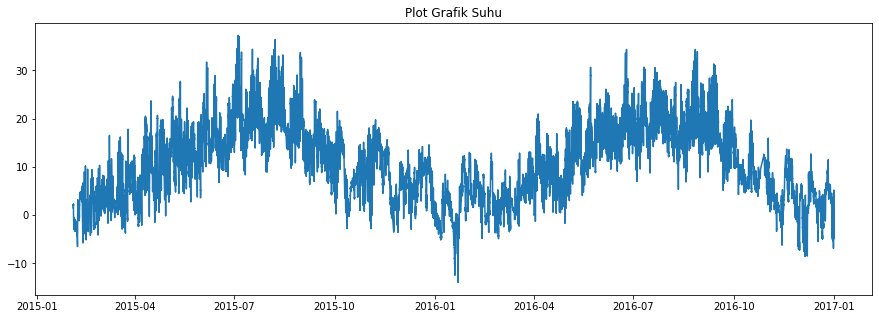

In [4]:
# data yang digunakan berjumlah 100000 timestamp
df_used = df['T (degC)'].iloc[-100000:]
plt.figure(figsize=(15,5))
plt.plot(df_used.index, df_used)
plt.title('Plot Grafik Suhu')
plt.show()

In [5]:
split_fraction = 0.8
train_split = int(split_fraction * int(df_used.shape[0]))
step = 6
past = 288
future = 16

In [6]:
# fungsi normalisasi dilakukan hanya pada data train
def normalize(data, train_split):
    data_mean = data[0:train_split - 1].mean(axis=0)
    data_std = data[0:train_split - 1].std(axis=0)
    return (data - data_mean) / data_std

In [7]:
print("sebelum dilakukan normalisasi: \n",df_used.head())

sebelum dilakukan normalisasi: 
 Date Time
2015-02-03 11:20:00    1.53
2015-02-03 11:30:00    1.72
2015-02-03 11:40:00    1.94
2015-02-03 11:50:00    2.03
2015-02-03 12:00:00    1.91
Name: T (degC), dtype: float64


In [8]:
series_normed = normalize(df_used.values, train_split)
series_normed = pd.DataFrame(series_normed)
print("setelah dilakukan normalisasi",series_normed.head())

setelah dilakukan normalisasi           0
0 -1.185265
1 -1.161194
2 -1.133322
3 -1.121920
4 -1.137123


In [9]:
train_data = (series_normed.loc[0 : train_split - 1]).values.reshape(-1)
val_data = (series_normed.loc[train_split:]).values.reshape(-1)
print("jumlah training data ", len(train_data))
print("jumlah validasi data ", len(val_data))

jumlah training data  80000
jumlah validasi data  20000


In [10]:
input_length = 10
n_feature = 1
batch_size = 128

In [11]:
train_generator = TimeseriesGenerator(train_data, train_data, length=input_length, batch_size=batch_size)

In [12]:
val_generator = TimeseriesGenerator(val_data, val_data, length=input_length, batch_size=batch_size)

In [13]:
for tr,_ in train_generator:
  input_shape_train = tr.shape
  break
for tr,_ in val_generator:
  input_shape_val = tr.shape
  break
print("Input shape train: ", input_shape_train)
print("Input shape val: ", input_shape_val)
assert input_shape_train==input_shape_val

Input shape train:  (128, 10)
Input shape val:  (128, 10)


In [14]:
min_data = df_used.values.min()
max_data = df_used.values.max()
print("minimum data series: ", min_data)
print("maximum data series: ", max_data)
mae_min = (max_data - min_data) * 0.1
mae_min = abs(min_data + mae_min)
print("minimum mae: ", mae_min)

minimum data series:  -13.93
maximum data series:  37.28
minimum mae:  8.809


In [15]:
class CustomCallback(Callback):

  def __init__(self, min_mae=None, use_mae_stop=False):
    self.min_mae = min_mae
    self.use_mae_stop = use_mae_stop

  def on_train_begin(self, logs={}):
    self.times = []

  def on_epoch_begin(self, epoch, logs={}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, epoch, logs={}):
    self.times.append(time.time() - self.epoch_time_start)
    if self.use_mae_stop==True:
      if logs.get('mae')<self.min_mae:
        self.model.stop_training = True

# disini saya sengaja tidak menggunakan mae stop 
# meskipun sudah saya sediakan callback mae stop
# hanya ingin eksperiment di beberapa iterasi saja
cust_callback = CustomCallback()
path_checkpoint = "checkpoin_timerseries.h5"
es_callback = EarlyStopping(monitor="mae", min_delta=0, patience=10)
modelckpt_callback = ModelCheckpoint(
    monitor="mae",
    filepath=path_checkpoint,
    verbose=1,
    mode='min',
    save_best_only=True,
)

In [16]:
# LSTM featuring GRU
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(input_length, n_feature)))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(GRU(5))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 16)            32        
_________________________________________________________________
lstm (LSTM)                  (None, 10, 16)            2112      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 10)            1080      
_________________________________________________________________
gru (GRU)                    (None, 5)                 255       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 3,485
Trainable params: 3,485
Non-trainable params: 0
_________________________________________________________________


In [17]:
learning_rate=0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, metrics=["mae"], loss=Huber())

In [18]:
epochs = 10
history = model.fit(
  train_generator,
  epochs=epochs,
  validation_data=val_generator,
  callbacks=[es_callback, modelckpt_callback, cust_callback],
)

Epoch 1/10
624/625 [============================>.] - ETA: 0s - loss: 0.0420 - mae: 0.1759
Epoch 00001: mae improved from inf to 0.17578, saving model to checkpoin_timerseries.h5
625/625 [==============================] - 10s 16ms/step - loss: 0.0419 - mae: 0.1758 - val_loss: 0.0088 - val_mae: 0.0921
Epoch 2/10
623/625 [============================>.] - ETA: 0s - loss: 0.0085 - mae: 0.0942
Epoch 00002: mae improved from 0.17578 to 0.09412, saving model to checkpoin_timerseries.h5
625/625 [==============================] - 9s 14ms/step - loss: 0.0085 - mae: 0.0941 - val_loss: 0.0057 - val_mae: 0.0806
Epoch 3/10
623/625 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0712
Epoch 00003: mae improved from 0.09412 to 0.07118, saving model to checkpoin_timerseries.h5
625/625 [==============================] - 9s 14ms/step - loss: 0.0050 - mae: 0.0712 - val_loss: 0.0024 - val_mae: 0.0500
Epoch 4/10
624/625 [============================>.] - ETA: 0s - loss: 0.0031 - mae: 0.05

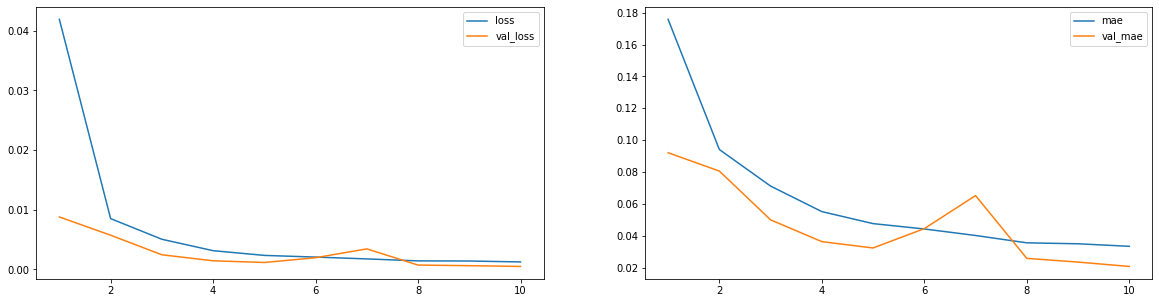

In [19]:
history_epoch = history.history
loss = history_epoch['loss']
mae = history_epoch['mae']
val_loss = history_epoch['val_loss']
val_mae = history_epoch['val_mae']
epochs_range = range(1, len(history.epoch)+1)
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.lineplot(epochs_range, loss, label="loss")
sns.lineplot(epochs_range, val_loss, label="val_loss")
plt.legend()
plt.subplot(1,2,2)
sns.lineplot(epochs_range, mae, label="mae")
sns.lineplot(epochs_range, val_mae, label="val_mae")
plt.legend()
plt.show()

In [20]:
valPredict = model.predict(val_generator.data)

In [21]:
len_time = 50
val_result = valPredict.reshape(-1)[:len_time]
val_actual_target = val_generator.targets[:len_time]

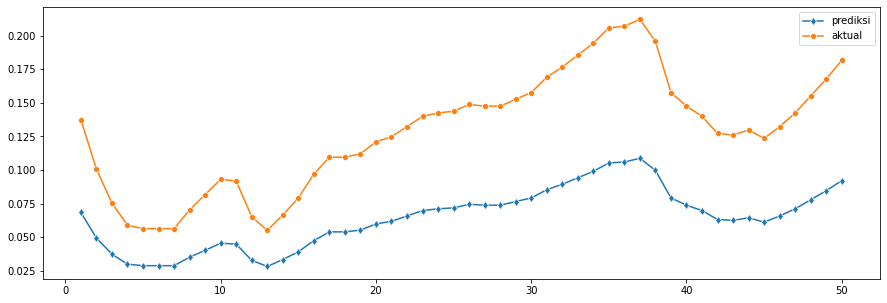

In [22]:
plot_time = range(1, len_time+1)
plt.figure(figsize=(15,5))
sns.lineplot(plot_time, val_result, label="prediksi", marker="d")
sns.lineplot(plot_time, val_actual_target, label="aktual", marker="o")
plt.show()

In [23]:
print("mae minimum skala data: ",mae_min)
print("mae hasil testing: ", mean_absolute_error(valPredict, val_generator.targets))

mae minimum skala data:  8.809
mae hasil testing:  0.4612547393436837
